# 영화 감성 분석 - 랜덤 포레스트

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import pickle

In [ ]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/data/'

# 학습 데이터를 읽어온다.
with open(DATA_PATH + 'popcorn.pkl', 'rb') as f:
    x_text, _, y_target, _ = pickle.load(f)

In [ ]:
vectorizer = CountVectorizer(analyzer="word", max_features=5000)
x_feat = vectorizer.fit_transform(x_text)

In [ ]:
# 학습 데이터와 시험 데이터로 분리한다.
x_train, x_eval, y_train, y_eval = train_test_split(x_feat, y_target, test_size=0.2)
x_train.shape, x_eval.shape, y_train.shape, y_eval.shape

((20000, 5000), (5000, 5000), (20000,), (5000,))

In [ ]:
forest = RandomForestClassifier(n_estimators = 100)
forest.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
print('Accuracy: {:.4f}'.format(forest.score(x_eval, y_eval)))

Accuracy: 0.8396


---

# 영화 감성 분석 - LSTM

In [ ]:
# Word Embedding & LSTM을 이용한 감성분석
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pickle

In [ ]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/data/'

# 학습 데이터를 읽어온다.
with open(DATA_PATH + 'popcorn.pkl', 'rb') as f:
    # _, x_feat, y_target, word2idx = pickle.load(f)
     x_text, _, y_target, _ = pickle.load(f)

y_target = np.array(y_target).reshape(-1,1)

In [ ]:
VOCAB_SIZE = 20000 # 사전의 크기를 줄이기
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(x_text)
x_feat = tokenizer.texts_to_sequences(x_text)
# len(tokenizer.word_index)
word2idx = {k:v for k, v in tokenizer.word_index.items() if v < VOCAB_SIZE}
word2idx['<PAD>'] = 0

In [ ]:
word2idx

{'<OOV>': 1,
 'movi': 2,
 'film': 3,
 'one': 4,
 'like': 5,
 'time': 6,
 'good': 7,
 'make': 8,
 'charact': 9,
 'get': 10,
 'see': 11,
 'watch': 12,
 'stori': 13,
 'even': 14,
 'would': 15,
 'realli': 16,
 'well': 17,
 'scene': 18,
 'look': 19,
 'show': 20,
 'much': 21,
 'end': 22,
 'peopl': 23,
 'bad': 24,
 'go': 25,
 'great': 26,
 'also': 27,
 'first': 28,
 'love': 29,
 'think': 30,
 'way': 31,
 'act': 32,
 'play': 33,
 'dont': 34,
 'made': 35,
 'thing': 36,
 'could': 37,
 'know': 38,
 'say': 39,
 'seem': 40,
 'work': 41,
 'plot': 42,
 'two': 43,
 'year': 44,
 'actor': 45,
 'come': 46,
 'mani': 47,
 'seen': 48,
 'take': 49,
 'want': 50,
 'life': 51,
 'never': 52,
 'littl': 53,
 'best': 54,
 'tri': 55,
 'man': 56,
 'ever': 57,
 'give': 58,
 'better': 59,
 'still': 60,
 'perform': 61,
 'find': 62,
 'feel': 63,
 'part': 64,
 'back': 65,
 'director': 66,
 'use': 67,
 'someth': 68,
 'actual': 69,
 'interest': 70,
 'im': 71,
 'lot': 72,
 'real': 73,
 'old': 74,
 'cast': 75,
 'though': 76,


In [ ]:
len(word2idx)

20000

In [ ]:
tokenizer.word_index['<OOV>'] # out of vocabulary

1

In [ ]:
x_feat[0]

[9, 7, 2, 4, 7, 1, 2, 8, 4, 2, 3, 1, 4, 3, 1, 3, 3]

In [ ]:
# 각 리뷰의 길이를 max_seq_len로 맞춘다. 길면 자르고, 짧으면 padding을 추가한다.
MAX_SEQ_LEN = 174
x_data_pad = pad_sequences(x_feat, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# 학습 데이터와 시험 데이터로 분리한다.
x_train, x_test, y_train, y_test = train_test_split(x_data_pad, y_target, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((20000, 174), (5000, 174), (20000, 1), (5000, 1))

In [ ]:
# Embedding & LSTM 모델을 생성한다.
vocab_size = len(word2idx)
EMBEDDING_DIM = 32
HIDDEN_DIM = 64

x_input = Input(batch_shape=(None, x_train.shape[1]))
e_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM)(x_input)
e_layer = Dropout(rate=0.5)(e_layer)
r_layer = LSTM(HIDDEN_DIM, dropout=0.5)(e_layer)
y_output = Dense(1, activation='sigmoid')(r_layer)

model = Model(x_input, y_output)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 174)]             0         
                                                                 
 embedding (Embedding)       (None, 174, 32)           640000    
                                                                 
 dropout (Dropout)           (None, 174, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 664,897
Trainable params: 664,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 1024, epochs = 50)

Epoch 1/50
20/20 [==============================] - 35s 2s/step - loss: 0.6933 - val_loss: 0.6932
Epoch 2/50
20/20 [==============================] - 29s 1s/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/50
20/20 [==============================] - 29s 1s/step - loss: 0.6930 - val_loss: 0.6930
Epoch 4/50
20/20 [==============================] - 28s 1s/step - loss: 0.6929 - val_loss: 0.6930
Epoch 5/50
20/20 [==============================] - 29s 1s/step - loss: 0.6929 - val_loss: 0.6929
Epoch 6/50
20/20 [==============================] - 28s 1s/step - loss: 0.6927 - val_loss: 0.6929
Epoch 7/50
20/20 [==============================] - 28s 1s/step - loss: 0.6926 - val_loss: 0.6928
Epoch 8/50
20/20 [==============================] - 28s 1s/step - loss: 0.6927 - val_loss: 0.6927
Epoch 9/50
20/20 [==============================] - 28s 1s/step - loss: 0.6924 - val_loss: 0.6926
Epoch 10/50
20/20 [==============================] - 28s 1s/step - loss: 0.6922 - val_loss: 0.6925
Epoch 11/50
20/20 [

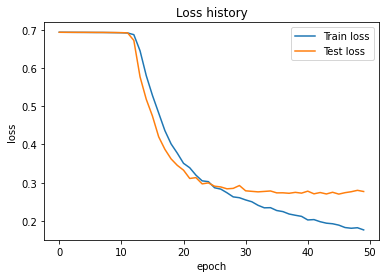

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.where(pred > 0.5, 1, 0)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))


Accuracy = 89.10 %


---
# 영화감성분석 - CNN

In [2]:
# Word Embedding & CNN을 이용한 감성분석
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pickle

In [3]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/data/'

# 학습 데이터를 읽어온다.
with open(DATA_PATH + 'popcorn.pkl', 'rb') as f:
    x_text, _, y_target, _ = pickle.load(f)

y_target = np.array(y_target).reshape(-1,1)

In [4]:
# 사전이 너무 크다. 줄여보자.
VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(x_text)
x_feat = tokenizer.texts_to_sequences(x_text)
word2idx = {k:v for k, v in tokenizer.word_index.items() if v < VOCAB_SIZE}
word2idx['<PAD>'] = 0

In [5]:
# 각 리뷰의 길이를 max_seq_len로 맞춘다. 길면 자르고, 짧으면 padding을 추가한다.
MAX_SEQ_LEN = 174
x_data_pad = pad_sequences(x_feat, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# 학습 데이터와 시험 데이터로 분리한다.
x_train, x_test, y_train, y_test = train_test_split(x_data_pad, y_target, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((20000, 174), (5000, 174), (20000, 1), (5000, 1))

In [6]:
# CNN 모델을 빌드한다.
VOCAB_SIZE = len(word2idx)
EMB_SIZE = 32
NUM_FILTER = 32

# Convolution & Pooling
def conv1d_maxpool(x, k):
    conv = Conv1D(filters=NUM_FILTER, kernel_size=k, activation='relu',
               kernel_regularizer=regularizers.l2(0.005))(x)
    return GlobalMaxPool1D()(conv)

x_input = Input(batch_shape=(None, x_train.shape[1]))
emb = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(x_input)
emb = Dropout(rate=0.5)(emb)

pool1 = conv1d_maxpool(emb, k=3)  # 3-gram
pool2 = conv1d_maxpool(emb, k=4)  # 4-gram
pool3 = conv1d_maxpool(emb, k=5)  # 5-gram
concat = Concatenate()([pool1, pool2, pool3])
y_output = Dense(1, activation='sigmoid')(concat)

model = Model(x_input, y_output)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 174, 32)      640000      ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 174, 32)      0           ['embedding[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 172, 32)      3104        ['dropout[0][0]']                
                                                                                              

In [10]:
# 학습
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 1024, epochs = 30)

Epoch 1/30
20/20 [==============================] - 1s 61ms/step - loss: 0.2010 - val_loss: 0.4239
Epoch 2/30
20/20 [==============================] - 1s 53ms/step - loss: 0.1945 - val_loss: 0.4244
Epoch 3/30
20/20 [==============================] - 1s 53ms/step - loss: 0.1938 - val_loss: 0.4242
Epoch 4/30
20/20 [==============================] - 1s 52ms/step - loss: 0.1908 - val_loss: 0.4259
Epoch 5/30
20/20 [==============================] - 1s 53ms/step - loss: 0.1878 - val_loss: 0.4265
Epoch 6/30
20/20 [==============================] - 1s 53ms/step - loss: 0.1836 - val_loss: 0.4280
Epoch 7/30
20/20 [==============================] - 1s 58ms/step - loss: 0.1795 - val_loss: 0.4288
Epoch 8/30
20/20 [==============================] - 1s 53ms/step - loss: 0.1780 - val_loss: 0.4287
Epoch 9/30
20/20 [==============================] - 1s 52ms/step - loss: 0.1765 - val_loss: 0.4299
Epoch 10/30
20/20 [==============================] - 1s 54ms/step - loss: 0.1732 - val_loss: 0.4311
Epoch 11/

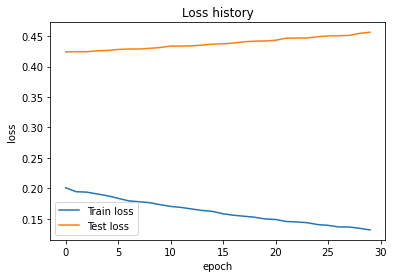

In [11]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [12]:
# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.where(pred > 0.5, 1, 0)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))


Accuracy = 83.60 %
